In [ ]:
!pip install gradio
!pip install Augmentor

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,GlobalAveragePooling2D,MaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
import pathlib as pa
import glob
import matplotlib.pyplot as plt
import Augmentor

In [ ]:
train=pa.Path('/content/drive/MyDrive/Data/Skin Cancer/Train/')
test=pa.Path('/content/drive/MyDrive/Data/Skin Cancer/Test/')

In [ ]:
folders=glob.glob('/content/drive/MyDrive/Data/Skin Cancer/Train/*')
folders

['/content/drive/MyDrive/Data/Skin Cancer/Train/pigmented benign keratosis',
 '/content/drive/MyDrive/Data/Skin Cancer/Train/seborrheic keratosis',
 '/content/drive/MyDrive/Data/Skin Cancer/Train/dermatofibroma',
 '/content/drive/MyDrive/Data/Skin Cancer/Train/nevus',
 '/content/drive/MyDrive/Data/Skin Cancer/Train/vascular lesion',
 '/content/drive/MyDrive/Data/Skin Cancer/Train/melanoma',
 '/content/drive/MyDrive/Data/Skin Cancer/Train/squamous cell carcinoma',
 '/content/drive/MyDrive/Data/Skin Cancer/Train/actinic keratosis',
 '/content/drive/MyDrive/Data/Skin Cancer/Train/basal cell carcinoma']

# Total Images

In [ ]:
total_train=len(list(train.glob('*/*.jpg')))
print("Train Images :",total_train)
total_test=len(list(test.glob('*/*.jpg')))
print("Test Images :",total_test)

Train Images : 2239
Test Images : 118


# Import Data into Tensorflow Object

In [ ]:
IMG_SIZE=[224,224]
BATCH_SIZE=32
train_ds=tf.keras.utils.image_dataset_from_directory(train,validation_split=0.2,subset='training',shuffle=True,
                                                     batch_size=BATCH_SIZE,image_size=IMG_SIZE,seed=123)
valid_ds=tf.keras.utils.image_dataset_from_directory(train,validation_split=0.2,subset='validation',shuffle=True,
                                                     batch_size=BATCH_SIZE,image_size=IMG_SIZE,seed=123)

test_t = tf.keras.utils.image_dataset_from_directory(test, shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)

Found 20239 files belonging to 9 classes.
Using 16192 files for training.
Found 20239 files belonging to 9 classes.
Using 4047 files for validation.
Found 118 files belonging to 9 classes.


# Check Train Classes

In [ ]:
names=train_ds.class_names
names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [ ]:
for imgbatch,labelbatch in train_ds.take(1):
  print(imgbatch.shape)
  print(labelbatch.numpy())

(32, 224, 224, 3)
[3 1 1 6 2 7 6 3 5 0 3 8 4 7 1 4 4 7 2 1 5 2 7 4 2 5 2 6 1 7 5 6]


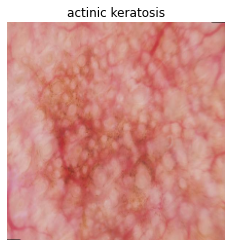

In [ ]:
for img,label in train_ds.take(1):
  plt.imshow(img[0].numpy().astype('uint8'))
  plt.title(names[label[0]])
  plt.axis('off')


# Visualize Random Images

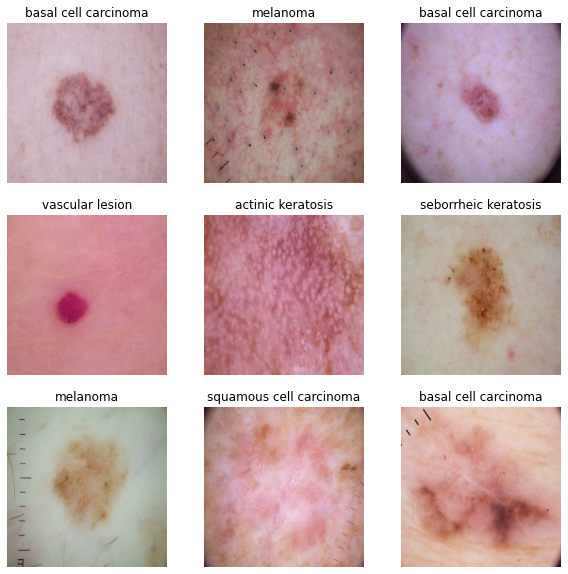

In [ ]:
fig=plt.figure(figsize=(10,10))
for img,label in train_ds.take(1):
  for i in range(9):
    fig.add_subplot(3,3,i+1),plt.imshow(img[i].numpy().astype('uint8'))
    plt.title(names[label[i]])
    plt.axis('off')

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

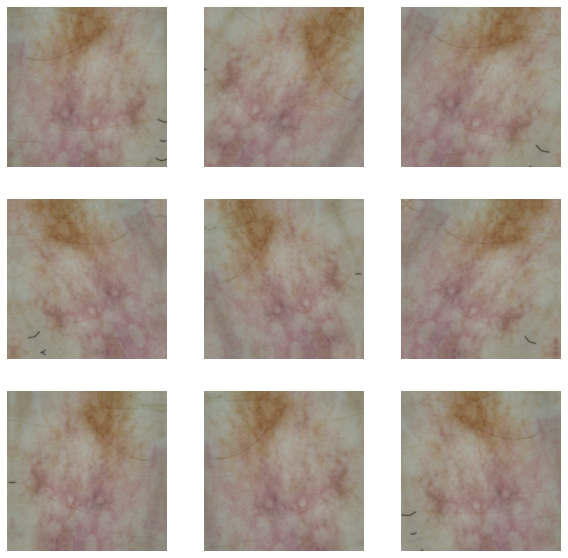

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
IMG_SHAPE = IMG_SIZE + [3]
base_model = ResNet50(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
base_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
inputs = base_model.input
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
global_average_layer = GlobalAveragePooling2D()
x=global_average_layer(x)
x = Dropout(0.2)(x)
outputs=Dense(len(folders), activation='softmax')(x)
model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=valid_ds)

Epoch 1/10
281/281 [==============================] - 335s 1s/step - loss: 1.3812 - accuracy: 0.5060 - val_loss: 1.0996 - val_accuracy: 0.6044
Epoch 2/10
281/281 [==============================] - 83s 295ms/step - loss: 0.9919 - accuracy: 0.6390 - val_loss: 0.9408 - val_accuracy: 0.6600
Epoch 3/10
281/281 [==============================] - 83s 294ms/step - loss: 0.8663 - accuracy: 0.6826 - val_loss: 1.0250 - val_accuracy: 0.6235
Epoch 4/10
281/281 [==============================] - 82s 294ms/step - loss: 0.8015 - accuracy: 0.7062 - val_loss: 0.9269 - val_accuracy: 0.6489
Epoch 5/10
281/281 [==============================] - 82s 293ms/step - loss: 0.7546 - accuracy: 0.7241 - val_loss: 0.8514 - val_accuracy: 0.6751
Epoch 6/10
281/281 [==============================] - 82s 293ms/step - loss: 0.7296 - accuracy: 0.7320 - val_loss: 0.8030 - val_accuracy: 0.6969
Epoch 7/10
281/281 [==============================] - 82s 292ms/step - loss: 0.7005 - accuracy: 0.7417 - val_loss: 0.7529 - val_accu

# Classes are Imbalance.

In [ ]:
class_size = {}
for name in names:
    class_size[name] = len(list(train.glob(name+'/*.jpg')))

class_size

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

# Check classes in DataFrame

In [ ]:
import pandas as pd
df=pd.DataFrame(class_size.items(),index=list(class_size),columns=['Disease Name','Count'])
df.head()
df.drop(['Disease Name'],axis=1,inplace=True)
df.head()

,Count
actinic keratosis,114
basal cell carcinoma,376
dermatofibroma,95
melanoma,438
nevus,357


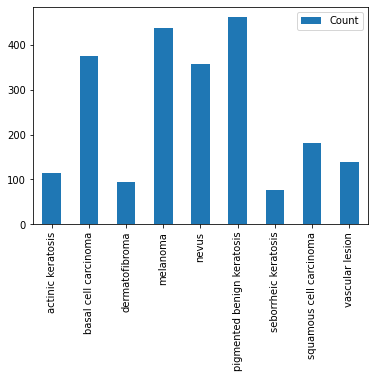

In [ ]:
df.plot.bar()

In [ ]:
# Unfreeze Top Layer
base_model.trainable=True
# Layers in Base Model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


# Reduce Learning Rate
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

fine_tune_epochs = 10
initial_epochs=10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_ds)

Number of layers in the base model:  175
Epoch 10/20
 31/281 [==>...........................] - ETA: 2:54 - loss: 0.6322 - accuracy: 0.7823

KeyboardInterrupt: ignored

# Using Augmentator to create more samples.

In [ ]:
trn_pt='/content/drive/MyDrive/Data/Skin Cancer/Train/'
for i in names:
  sample=Augmentor.Pipeline(trn_pt+i)
  sample.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  sample.sample(1000) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Skin Cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F00AAD6BE90>: 100%|██████████| 1000/1000 [00:44<00:00, 22.31 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Skin Cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F00AAC0CB10>: 100%|██████████| 1000/1000 [00:42<00:00, 23.28 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Skin Cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F00AAD33D50>: 100%|██████████| 1000/1000 [00:47<00:00, 21.00 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Skin Cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F00AA80BE10>: 100%|██████████| 1000/1000 [03:34<00:00,  4.66 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Skin Cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F00AA703250>: 100%|██████████| 1000/1000 [03:09<00:00,  5.27 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Skin Cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F00AADD9E50>: 100%|██████████| 1000/1000 [00:45<00:00, 21.87 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Skin Cancer/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F00AAC09F10>: 100%|██████████| 1000/1000 [01:38<00:00, 10.12 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Skin Cancer/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0127B90650>: 100%|██████████| 1000/1000 [00:43<00:00, 22.90 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Skin Cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F00AC8DFF50>: 100%|██████████| 1000/1000 [00:44<00:00, 22.44 Samples/s]


# Image in Output Directory

In [ ]:
output_dir = pa.Path('/content/drive/MyDrive/Data/Skin Cancer/Train/')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

27000


# Using Augmentory Images

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 29239 files belonging to 9 classes.
Using 23392 files for training.
Found 29239 files belonging to 9 classes.
Using 5847 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=valid_ds)

NameError: ignored